### Imports

In [14]:
from collections import defaultdict
import gymnasium as gym
import gym_simplegrid
from gym_simplegrid import envs
import matplotlib
import numpy as np
import os
# import shutil
# import torch
# import torchvision
import json
import copy
# from torch.utils.tensorboard import SummaryWriter
import scipy
import matplotlib.pyplot as plt
# from logger import Logger
from typing import Dict, List, Tuple
from collections import deque
import random


from plot import plot_metric

### Define the agents

In [15]:
from agents import DoubleQ_Agent, VQ_Agent, Q_Agent

In [16]:
importance_sampling_ratio= np.array([0.5, 0.9, 1.4, 4.0, 1.1])
mask = np.logical_and(importance_sampling_ratio > 0.8, importance_sampling_ratio < 1.2)
print(mask)

[False  True False False  True]


### Define function run

In [17]:
from buffer import ReplayBuffer
from utils import Logger

def run(obstacle_map, start_loc, goal_loc, config, repeat_idx, total_steps, logger:Logger):
    
    env = gym.make(
        'SimpleGrid-v0', 
        obstacle_map=obstacle_map, 
        # render_mode='human',
        render_mode=None,
        max_episode_steps=300,
    )
    
    # agent = Q_Agent(alpha=0.1, gamma=0.99, action_space=env.action_space, observation_space=env.observation_space, eps_start=0.2, eps_end=0.00, eps_dec=0.99999, random_init=True)
    if config['algo_name'] == 'VQ-learning':
        agent = VQ_Agent(alpha=config["alpha"], gamma=config["gamma"], action_space=env.action_space, observation_space=env.observation_space, eps_start=config["eps_start"], eps_end=config["eps_end"], eps_dec=config["eps_decay"], random_value_init=config["random_value_init"], alpha_v=config["alpha_v"], alpha_q=config["alpha_q"], importance_sampling=config["importance_sampling"])
    elif config['algo_name'] == 'Q-learning':
        agent = Q_Agent(alpha=config["alpha"], gamma=config["gamma"], action_space=env.action_space, observation_space=env.observation_space, eps_start=config["eps_start"], eps_end=config["eps_end"], eps_dec=config["eps_decay"], random_value_init=config["random_value_init"])
    elif config['algo_name'] == 'DoubleQ-learning':
        agent = DoubleQ_Agent(alpha=config["alpha"], gamma=config["gamma"], action_space=env.action_space, observation_space=env.observation_space, eps_start=config["eps_start"], eps_end=config["eps_end"], eps_dec=config["eps_decay"], random_value_init=config["random_value_init"])
    else:
        raise ValueError(f"algo_name: {config['algo_name']} not supported")

    replay_buffer = ReplayBuffer(obs_dim=1, size=config['buffer_size'], batch_size=config['batch_size'])
        
    obs, info = env.reset(options={'start_loc':start_loc, 'goal_loc':goal_loc})
    # done = env.unwrapped.done
    done=False
    truncated = False
    episode_reward = 0
    episode_idx = 0
    learn_info_list = []
    trajectory = [obs]
    n_reset_buffer = 0
    n_learn = 0
    n_on_policy = 0
    running_avg = 1.0
    for step in range(total_steps):
        if done or truncated:
            # print(f'repeat_idx: {repeat_idx} | step: {step} | episode reward:{episode_reward} | maxQ: {np.max(agent.Q)} | eps: {agent.eps}')
            data = {"repeat_idx": repeat_idx, "episode_idx": episode_idx, "step": step, "reward": episode_reward, "maxQ": np.max(agent.Q), "eps": agent.eps, "len_episode": len(trajectory)}
            data.update(info)
            #update done and truncated
            data.update({"done": done, "truncated": truncated})

            # data.update(learn_info)
            logger.dump_episodic_data(data)

            obs, info = env.reset(options={'start_loc':start_loc, 'goal_loc':goal_loc})
            episode_reward = 0
            episode_idx += 1
            
            # print(f"repeat:{repeat_idx} trajectory: {trajectory} \n")
            # with open("results/temp.log", 'a') as f:
            #     f.write(f"repeat:{repeat_idx} step {step} done {done} truncated {truncated}trajectory: {trajectory}" + '\n')
            trajectory = [obs]
            
        if (step+1) % 100 == 0:    
            logger.dump({"repeat_idx": repeat_idx,"step": step})
            
        action, action_prob = agent.choose_action(obs)
        new_obs, reward, done, truncated, info = env.step(action)
        replay_buffer.store(obs, action, reward, new_obs, float(done), action_prob)
        if len(replay_buffer) >= replay_buffer.batch_size:
            if config["importance_sampling"]>0:
                trans = replay_buffer.sample_batch()
                if config['syncVQ']:
                    learn_info = agent.learn_syncVQ(trans['obs'], trans['acts'], trans['rews'], trans['next_obs'], trans['done'], trans['prob_acts'])
                else:
                    learn_info = agent.learn(trans['obs'], trans['acts'], trans['rews'], trans['next_obs'], trans['done'], trans['prob_acts'])
                n_learn += 1
                n_on_policy += 1
                # running_avg = (running_avg + np.mean(learn_info['mask_'])) / (n_on_policy + 1)
                # running_avg = running_avg * 0.5 + 0.5 * np.mean(learn_info['mask_'])
                # running_avg = np.mean(buf)
                running_avg = np.mean(learn_info['mask_'])
                if running_avg < config["importance_sampling"]:
                    replay_buffer.reset()
                    n_reset_buffer += 1
                    if config['syncVQ']:
                        agent.sync_VQ()
                    # running_avg = 0
                    # n_on_policy = 0
                else: 
                    pass
                    # print(f"np.mean(l_on_policy): {np.mean(l_on_policy)}")
                
                learn_info.update(
                    {
                        "n_learn": n_learn, 
                        "n_reset_buffer": n_reset_buffer, 
                        "n_on_policy": n_on_policy,
                        "running_avg": running_avg,
                    }
                    )
                learn_info_list.append(learn_info)
                for k, v in learn_info.items():
                    logger.log(key=k, value=v)
            else:
                trans = replay_buffer.sample_batch()
                learn_info = agent.learn(trans['obs'], trans['acts'], trans['rews'], trans['next_obs'], trans['done'], trans['prob_acts'])
                learn_info_list.append(learn_info)
                for k, v in learn_info.items():
                        logger.log(key=k, value=v)
        trajectory.append(new_obs)
        # print(f"transition: {obs} -> {action} -> {new_obs} | reward: {reward} | done: {done}")
        # print(learn_info)
        # print(agent.V)
        # print(agent.Q)
        episode_reward += reward
        obs = new_obs


    print(f"n_reset_buffer: {n_reset_buffer}, n_learn: {n_learn}")    
    env.close()           


### Run Repeats

In [18]:
import numpy as np
obstacle_map = [
        "000",
        "000",
        "000",
    ]
start_loc = (1,1)
goal_loc = [(0,0), (2,2)]
map_name = "square"
map_str = np.asarray(obstacle_map, dtype='c')
print(map_str)
map_int = np.asarray(map_str, dtype=int)
print(map_int)

env = gym.make(
    'SimpleGrid-v0', 
    obstacle_map=obstacle_map, 
    # render_mode='human',
    max_episode_steps=300,
    render_mode=None,
)
print(env.observation_space.n)
obs, info = env.reset(options={'start_loc':start_loc, 'goal_loc':goal_loc})
print(obs)
print(np.zeros(1))
print(env._max_episode_steps)

[[b'0' b'0' b'0']
 [b'0' b'0' b'0']
 [b'0' b'0' b'0']]
[[0 0 0]
 [0 0 0]
 [0 0 0]]
9
4
[0.]
300


In [19]:
# [Load a custom map]
obstacle_map = [
        "0000000",
        "0000000",
        "0000000",
        "1110111",
        "0000000",
        "0000000",
        "0000000",
    ]
# start_loc = (0,2)
# goal_loc = [(6,2), (1,6)]

start_loc = (3,3)
goal_loc = [(0,3), (6,3)]
map_name = "2rooms_rwd0.1"

# obstacle_map = [
#         "000",
#         "000",
#     ]
# start_loc = (1,1)
# goal_loc = [(0,0), (1,2)]
# map_name = "2row"

# obstacle_map = [
#         "000",
#         "000",
#         "000",
#     ]
# start_loc = (1,1)
# goal_loc = [(0,0), (2,2)]
# map_name = "square"
n_repeat = 5
total_steps = 200000
config = {
    "algo_name": "Q-learning",
    # "algo_name": "VQ-learning",
    # "algo_name": "DoubleQ-learning",
    "eps_start": 0.5,
    "eps_end": 0.00,
    "eps_decay": 0.99995,
    "alpha": 0.1,
    "gamma": 0.99,
    "random_value_init": True,
    "alpha_v": 0.1,
    "alpha_q": 0.1,
    "buffer_size": 1,
    "batch_size": 1,
    "importance_sampling": 0.0, # this will work as a threshold
    "syncVQ": False,
}
algo_name = config["algo_name"]
log_dir = f"results/{map_name}/{algo_name}/randinit{int(config['random_value_init'])}_eps{config['eps_start']}to{config['eps_end']}_decay{config['eps_decay']}_buffer{config['buffer_size']}_{config['batch_size']}_is{config['importance_sampling']}_syncVQ{int(config['syncVQ'])}_repeat{n_repeat}_steps{total_steps}" + "gaVQ-s_-a_--test"
print(log_dir)
log_paths = {
    "avg_meter": os.path.join(log_dir, "avg_meter.log"),
    "episodic": os.path.join(log_dir, "episodic.log"),
}
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
for log_path in log_paths.values():
    if os.path.exists(log_path):
        os.remove(log_path)

logger = Logger(log_paths=log_paths)

# algo = "VQ-learning"
# if results/temp.log exists, remove it
if os.path.exists("results/temp.log"):
    os.remove("results/temp.log")
for i_repeat in range(n_repeat):
    run(obstacle_map, start_loc, goal_loc, config=config, repeat_idx=i_repeat, total_steps=total_steps, logger=logger)
    print(f"repeat {i_repeat} done")


results/2rooms_rwd0.1/Q-learning/randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat5_steps200000gaVQ-s_-a_--test
n_reset_buffer: 0, n_learn: 0
repeat 0 done
n_reset_buffer: 0, n_learn: 0
repeat 1 done
n_reset_buffer: 0, n_learn: 0
repeat 2 done
n_reset_buffer: 0, n_learn: 0
repeat 3 done
n_reset_buffer: 0, n_learn: 0
repeat 4 done


In [29]:
log_dir = 'results/2rooms_rwd0.1/VQ-learning/randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat20_steps200000' + ""

### Plot Episodic Reward

results/2rooms_rwd0.1/Q-learning/randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat5_steps200000gaVQ-s_-a_--test


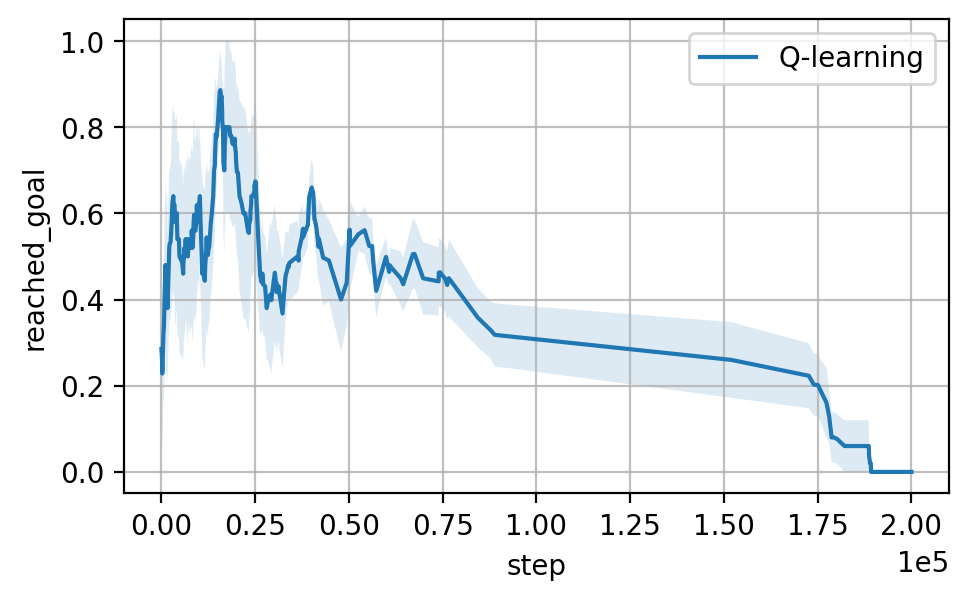

In [20]:
print(log_dir)
key_name = "step"
# value_name = "reward"
# value_name = "maxQ"
value_name = "reached_goal"
# value_name = "len_episode"
x_label = key_name
y_label = value_name
label_name = algo_name
log_path = os.path.join(log_dir, "episodic.log")
save_path = os.path.join(log_dir, f"step-{value_name}")
# log_path = os.path.join('results/2rooms_steps30000_alphaQ0.1', "episodic.log")
plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=label_name, interpolate=True, smooth=10, max_key=True, save_path=save_path)

# key_name = "step"
# # value_name = "maxQ"
# value_name = "reward"
# label_name = "VQ-learning1.0"
# log_path = os.path.join('results/2rooms_steps100000_raninit1_alphaV0.1_alphaQ1.0_eps0.3to0.00_decay0.9998_repeat10', "episodic.log")
# plot_metric(log_path, key_name, value_name, label_name=label_name, interpolate=True, smooth=10, max_key=True)

### Plot X for avg_meter.log

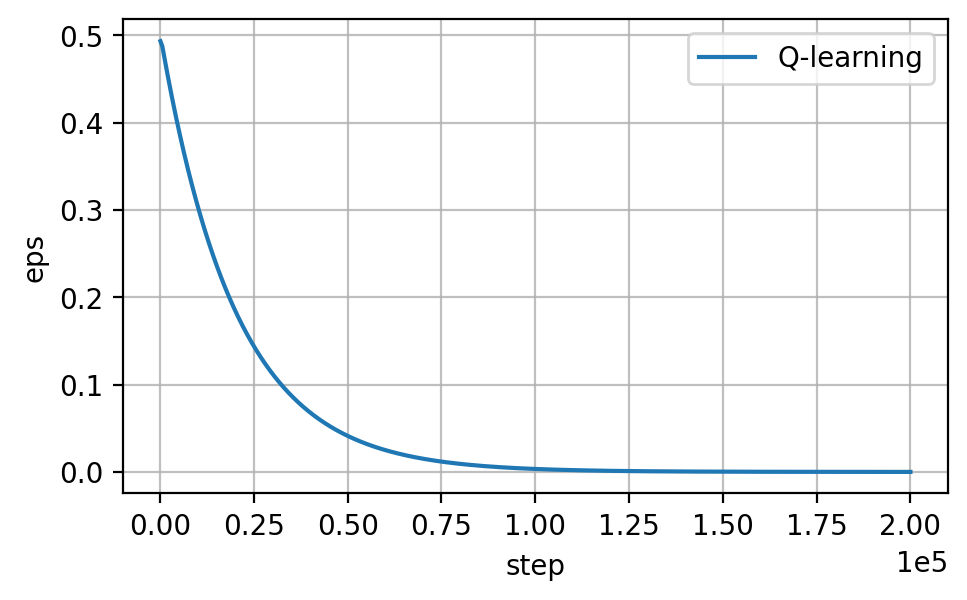

In [164]:
key_name = "step"
# value_name = "Q(s,a)"
# value_name = "maxQ"
value_name = "eps"
x_label = key_name
y_label = value_name
label_name = algo_name
# log_path = os.path.join(log_dir, "episodic.log")
log_path = os.path.join(log_dir, "avg_meter.log")
save_path = os.path.join(log_dir, f"step-{value_name}.png")

plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=label_name, interpolate=True, smooth=10, max_key=True, save_path=save_path)

### Plot V and Q

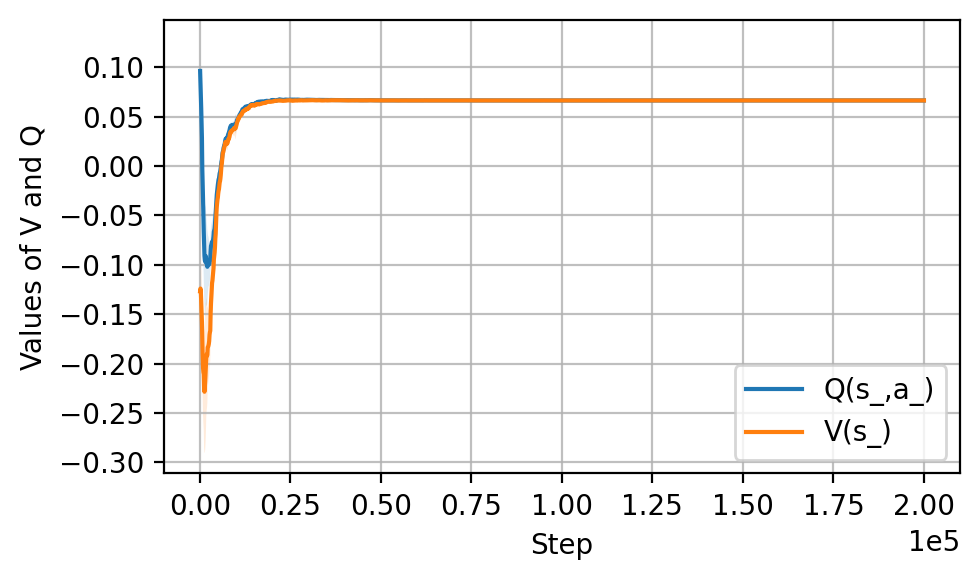

In [8]:

x_label = "Step"
y_label = 'Values of V and Q'

key_name = "step"
value_name = "Q(s_,a_)"
# value_name = "maxQ"
curve_name = value_name

log_path = os.path.join(log_dir, "avg_meter.log")
save_path = os.path.join(log_dir, "step-V-Q")

plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=curve_name, interpolate=False, smooth=10, max_key=True, save_path=False)
value_name = "V(s_)"
curve_name = value_name
plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=curve_name, interpolate=True, smooth=10, max_key=True, save_path=save_path)


# log_path = os.path.join(log_dir, "avg_meter.log")
# x_label = "step"
# y_label = "Q(s,a)"
# plot_metric(log_path, x_label, y_label, label_name="Q(s,a)", interpolate=False)
# x_label = "step"
# y_label = "V(s)"
# plot_metric(log_path, x_label, y_label, label_name="V(s)", interpolate=False)

### Plot mask_

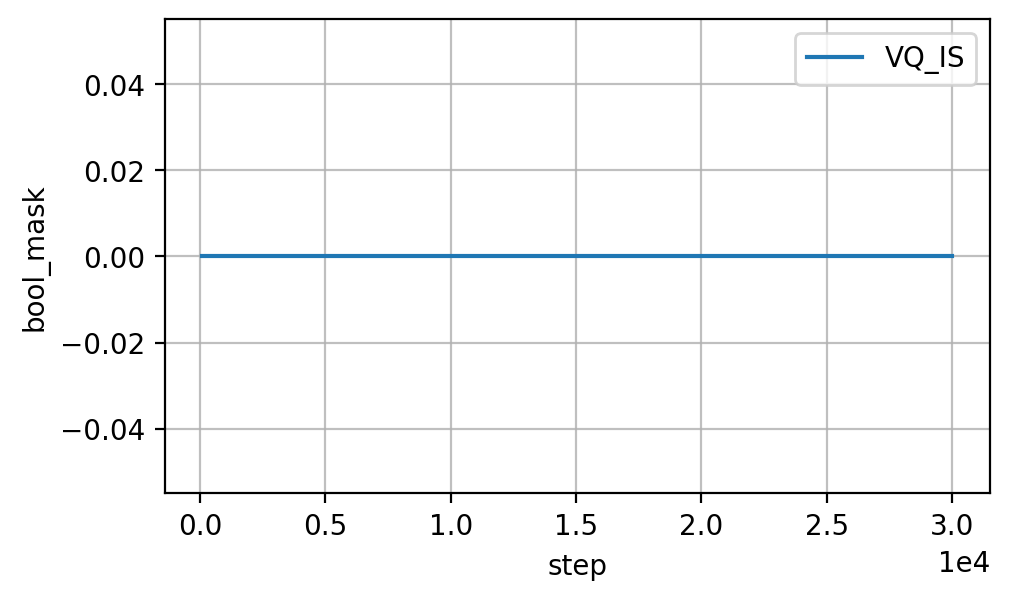

In [383]:
log_path = os.path.join(log_dir, "avg_meter.log")
key_name = x_label = "step"
value_name = y_label = "bool_mask"
label_name = "VQ_IS"
save_path = os.path.join(log_dir, "step-GoodImpSplRate.png")
plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=label_name, interpolate=True, smooth=10, max_key=True, save_path=save_path)


### Plot all runs

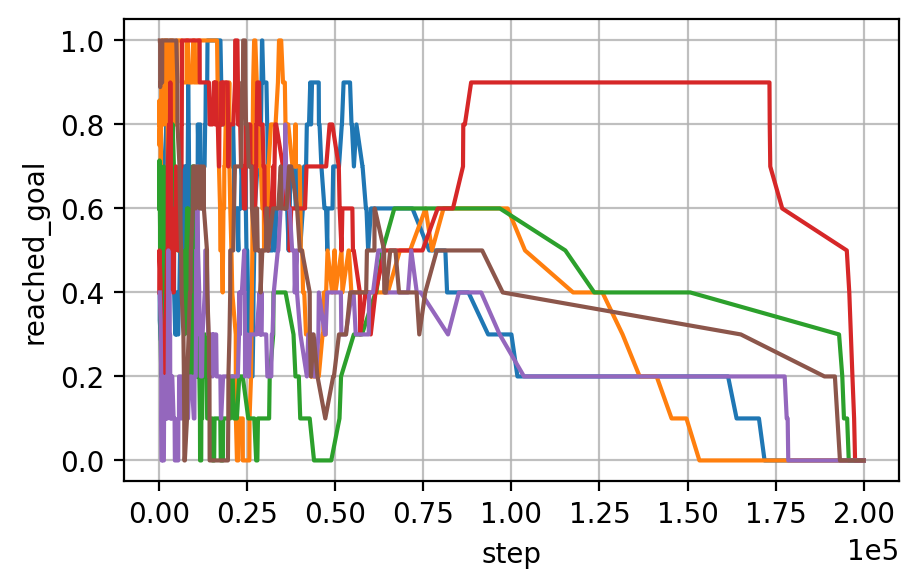

In [176]:
# log_dir = "results/2rooms_steps100000_raninit1_alphaV0.1_alphaQ1.0_eps0.3to0.00_decay0.9998_repeat10"
# log_path = os.path.join(log_dir, "avg_meter.log")
log_path = os.path.join(log_dir, "episodic.log")
x_label = "step"
# y_label = "reward"
# y_label = "maxQ"
y_label = "reached_goal"
# y_label = "len_episode"


save_path = os.path.join(log_dir, f"step-{y_label}-allruns")

smooth=10

last_idice = []
for i in range(n_repeat):
    # count number of lines for repeat i
    n_lines = 0
    with open(log_path, "r") as f:
        for line in f:
            data = json.loads(line)
            if data["repeat_idx"] == i:
                n_lines += 1
    last_idice.append(n_lines)
last_idice = np.array(last_idice)
# each element is the sum of the previous elements
last_idice = np.cumsum(last_idice)
last_idice = last_idice - 1

keys = []
values = []

with open(log_path, "r") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        if x_label in data and y_label in data:
            keys.append(data[x_label])
            values.append(data[y_label])        
        if i in last_idice:
            keys, values = np.array(keys), np.array(values)
            if smooth > 1 and values.shape[0] > 0:
                K = np.ones(smooth)
                ones = np.ones(values.shape[0])
                values = np.convolve(values, K, "same") / np.convolve(ones, K, "same")
            # plot data
            plt.plot(keys, values, label=f"rep_idx: {np.where(last_idice==i)[0][0]}")

            keys = []
            values = []


            
plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 10
plt.grid(alpha=0.8)
# plt.ylim(top=2.0)
# plt.legend(ncol=1)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
# save the plot to save_path
plt.savefig(f"{save_path}.png")
# plt.close()

### Compare algos

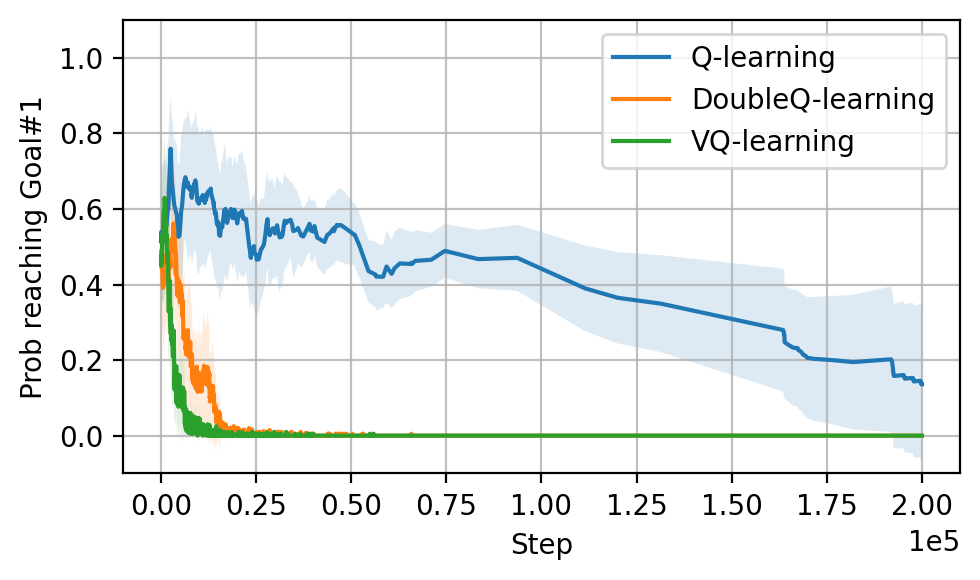

In [33]:
mode = "episodic" 
# mode = "avg_meter"
# [version 1]:
# log_dir1 = "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000"
# log_dir2 = "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000_QLearning"
# log_dir3 = "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000_DoubleQLearning"

# if mode == "episodic":
#     log_path1 = os.path.join(log_dir1, "episodic.log")
#     log_path2 = os.path.join(log_dir2, "episodic.log")
# else:
#     log_path1 = os.path.join(log_dir1, "avg_meter.log")
#     log_path2 = os.path.join(log_dir2, "avg_meter.log")
# save_path1 = os.path.join(log_dir1, "step-reward-compare-algos.png")
# save_path2 = os.path.join(log_dir2, "step-reward-compare-algos.png")
# print(log_path1)
# curve_name1 = "VQ-learning"
# curve_name2 = "Q-learning"
# key_name = x_label = "step"
# value_name = y_label = "reward"
# smooth=10


# plot_metric(log_path1, key_name, value_name, x_label, y_label, label_name=curve_name1, interpolate=True, smooth=10, max_key=True, save_path=False)
# plot_metric(log_path2, key_name, value_name, x_label, y_label, label_name=curve_name2, interpolate=True, smooth=10, max_key=True, save_path=save_path1)

# [version 2]:
# log_dirs = {
#     # "Q-learning" : "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000_QLearning",
#     "Q-learning": "results/2rooms/Q-learning/randinit1_eps0.3to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat10_steps60000",
#     # "DoubleQ-learning" : 'results/2rooms/DoubleQ-learning/randinit1_eps0.3to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat10_steps30000',
#     "DoubleQ-learning": "results/2rooms/DoubleQ-learning/randinit1_eps0.3to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat10_steps60000",
#     # "VQ-learning" : "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000",
#     "VQ-learning": 'results/2rooms/VQ-learning/randinit1_eps0.3to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat10_steps60000'
# }
# log_dirs = {
#     "Q-learning": 'results/2rooms/Q-learning/randinit1_eps0.3to0.0_decay0.9999_buffer1_1_is0.0_syncVQ0_repeat20_steps60000',
#     "DoubleQ-learning": 'results/2rooms/DoubleQ-learning/randinit1_eps0.3to0.0_decay0.9999_buffer1_1_is0.0_syncVQ0_repeat20_steps60000',
#     "VQ-learning": 'results/2rooms/VQ-learning/randinit1_eps0.3to0.0_decay0.9999_buffer1_1_is0.0_syncVQ0_repeat20_steps60000'
# }
algos = ["Q-learning", "DoubleQ-learning", "VQ-learning"]
dirs = [
    'randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat20_steps200000',
    'randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat20_steps200000',  
    'randinit1_eps0.5to0.0_decay0.99995_buffer1_1_is0.0_syncVQ0_repeat20_steps200000',    
]
log_dirs = {}
for algo, dir in zip(algos, dirs):
    log_dirs[algo] = f"results/2rooms_rwd0.1/{algo}/{dir}"
for i, (key, value) in enumerate(log_dirs.items()):
    if mode == "episodic":
        log_path = os.path.join(value, "episodic.log")
    else:
        log_path = os.path.join(value, "avg_meter.log")
    key_name = "step"
    x_label = "Step"
    # value_name = y_label = "reward"
    value_name = "reached_goal"
    y_label = "Prob reaching Goal#1"
    # value_name = y_label = "Q(s,a)"
    curve_name = key
    # save_path = os.path.join(value, f"step-{value_name}-acrossAlgos.png")

    # if i == len(log_dirs) - 1:
    #     plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=curve_name, interpolate=True, smooth=10, max_key=True, save_path=save_path)
    # else:
    plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=curve_name, interpolate=True, smooth=10, max_key=True, save_path=False)

plt.ylim(-0.1, 1.1)
plt.legend(loc="upper right", ncol=1)

save_dir = os.path.join("results/2rooms_rwd0.1/compareAlgos/", dirs[-1]+"")
save_path = os.path.join(save_dir, f"step-{value_name}-acrossAlgos")
# create save_dir if not exists 
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if save_path:
    plt.savefig(f"{save_path}")


# log_dir = "results/2rooms_randinit0_eps0.3to0.0_decay0.9998_buffer1_1_is0.0_syncVQ0_repeat5_steps30000"
# key_name = "step"
# value_name = "reward"
# # value_name = "maxQ"
# x_label = key_name
# y_label = value_name
# label_name = algo_name
# log_path = os.path.join(log_dir, "episodic.log")
# print(log_path)
# save_path = os.path.join(log_dir, "step-reward.png")
# # log_path = os.path.join('results/2rooms_steps30000_alphaQ0.1', "episodic.log")
# plot_metric(log_path, key_name, value_name, x_label, y_label, label_name=label_name, interpolate=True, smooth=10, max_key=True, save_path=False)